# Suitability Analysis of East Anglia for on-shore windfarms

* **Student ID:** 220002931

* **Date:** 10/12/2025

**Abstract:**

On shore wind energy is an under utilised resource. With growing energy demands and a desire to reduce fossil fuel usage identifying areas for wind generation within the UK is necessary. In this research I aim to determine whether an area of interest in East Anglia is suitable for the construction of an on shore windfarm based on a MCE map evaluation and further analysis in python using DBSCAN clustering.

**Keywords:** Wind Power, Suitabilty, England, Renewables, MCE

# GitHub Repository
- **GitHub Link:** [Add here the link to your repo]

## Declaration

> In submitting this assignment, I hereby confirm that I have read the University's statement on Good Academic Practice. The following work is my own. Significant academic debts and borrowings have been properly acknowledged and referenced.


**Table of Contents:**

* Introduction
* Methodology
* Results
* Discussion
* Conclusion
* Appendix
* References


# Introduction

Finding a replacement for fossil fuels and replacing the means of production with green and net zero green energy is an essential goal for the United Kingdom (Gov UK, 2021) with a fully low carbon power grid being a priority by 2035. The Climate change committee in 2025 indicated that a tripling of wind generation sites construction needed to occur for the UK to reach their carbon net zero goals. Current Government energy statistics show that between Q2 2024 and 2025 there was a net decrease in onshore wind generation further emphasising the need for on shore wind creation. This is a known gap in the UK energy infrastructure plan and is not being aided by the gap in planning leniency for sites such as windfarms (renewableUK, 2021). Several factors must be considered when choosing an area for a wind farm such as protected areas, local permissions, noise and visual impacts etc. (Gov UK, 2024) The coast of East Anglia has already been selected for a wind farm project which has worked well which suggests the on-shore locality has potential for wind farm suitability that needs to be reviewed (Scottish Power).

# Methodology

## Data Collection

Firstly, appropriate data had to be found and identified. Due to the scope of this project only a small number of factors could be analysed. Land use, Proximity to power, Proximity to rivers, Proximity to roads, terrain, Wind Power, and Areas of outstanding natural beauty were considered as these were considered to be some of the most important and had easily accessible data.

## Python Pre-processing


Collected data was uploaded to a google drive in order to be processed in a Jupyter notebook in Google Colab.
Appropriate libraries for pre processing were installed.


In [ ]:
!apt-get install -y libspatialindex-dev
!pip install geopandas shapely fiona pyproj rtree
import geopandas as gpd
import glob
import os
import pandas as pd
from shapely.geometry import box

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


A bounding box was created to crop data by and saved as a shapefile, this area was chosen to represent North East Anglia.

In [4]:
minx, miny, maxx, maxy = 350000, 550000, 400000, 600000

In [5]:
aoi_latlon = box(0.472412,52.626395,1.389771,52.968492)

aoi = gpd.GeoDataFrame(geometry=[aoi_latlon], crs="EPSG:4326").to_crs("EPSG:27700")

In [6]:
aoi.to_file("/content/drive/MyDrive/Colab Notebooks/GG3209_Final/data/aoi.shp")

Paths were created to save my data once it had been clipped by bounding box and raw data was coded to classify based on initial folder name.

Processing code was used to: Match CRS with area of interest, Skip files that did not intersect AOI, Clip files to contain no more than AOI, save these files.

In [ ]:
folder = r"/content/drive/MyDrive/Colab Notebooks/GG3209_Final/data"
aoi_path = r"/content/drive/MyDrive/Colab Notebooks/GG3209_Final/data/aoi.shp"
aoi = gpd.read_file(aoi_path)

paths = {
    "rivers": r"/content/drive/MyDrive/Colab Notebooks/GG3209_Final/data/clipped_Rivers",
    "roads": r"/content/drive/MyDrive/Colab Notebooks/GG3209_Final/data/clipped_Roads",
    "wind": r"/content/drive/MyDrive/Colab Notebooks/GG3209_Final/data/clipped_Wind",
    "terrain": r"/content/drive/MyDrive/Colab Notebooks/GG3209_Final/data/clipped_terrain",
    "power": r"/content/drive/MyDrive/Colab Notebooks/GG3209_Final/data/clipped_power",
    "landuse": r"/content/drive/MyDrive/Colab Notebooks/GG3209_Final/data/clipped_Landuse",
    "airports": r"/content/drive/MyDrive/Colab Notebooks/GG3209_Final/data/clipped_airports"
}
output_dirs = paths
for d in output_dirs.values():
    os.makedirs(d, exist_ok=True)

def classify_by_folder(path, base_input_folder):

    rel_path = os.path.relpath(path, base_input_folder)
    top_folder = rel_path.split(os.sep)[0].lower()

    if top_folder in ["rivers", "river"]:
        return "rivers"
    if top_folder in ["roads", "road"]:
        return "roads"
    if top_folder in ["wind"]:
        return "wind"
    if top_folder in ["terrain", "dem", "elevation"]:
        return "terrain"
    if top_folder in ["power", "elec", "grid"]:
        return "power"
    if top_folder in ["landuse", "land", "use"]:
        return "landuse"
    if top_folder in ["airports"]:
        return "airports"
    return "other"


all_files = glob.glob(os.path.join(folder, "**", "*"), recursive=True)

for path in all_files:

    if path == aoi_path:
        continue

    if not path.lower().endswith((".shp", ".zip")):
        continue

    category = classify_by_folder(path, folder)

    if category == "other":
        print(f"Skipping (unknown category): {path}")
        continue

    out_dir = output_dirs[category]

    try:

        if path.lower().endswith(".zip"):

            try:
                gdf = gpd.read_file(f"zip://{path}")
            except:

                import zipfile
                extract_dir = os.path.join("/tmp", os.path.basename(path).replace(".zip", ""))
                os.makedirs(extract_dir, exist_ok=True)
                with zipfile.ZipFile(path, 'r') as zip_ref:
                    zip_ref.extractall(extract_dir)
                shp_inside = glob.glob(os.path.join(extract_dir, "*.shp"))[0]
                gdf = gpd.read_file(shp_inside)
        else:
            gdf = gpd.read_file(path)


        if gdf.crs != aoi.crs:
            gdf = gdf.to_crs(aoi.crs)


        if gdf.intersects(aoi.union_all()).sum() == 0:
            print(f"Skipping (no overlap): {path}")
            continue


        clipped = gpd.clip(gdf, aoi)

        if clipped.empty:
            print(f"Skipping (empty after clip): {path}")
            continue


        base = os.path.basename(path).replace(".zip", "").replace(".shp", "") + "_clipped.shp"
        out_path = os.path.join(out_dir, base)
        clipped.to_file(out_path)
        print(f"Saved: {out_path}")

    except Exception as e:
        print(f"Error processing {path}: {e}")

Further processing was used to merge all files of one factor/criterion into one file for each geometry type (e.g. Rivers_polygons).

In [ ]:
base_dir = "/content/drive/MyDrive/Colab Notebooks/GG3209_Final/data"

folders = [
    "clipped_Roads",
    "clipped_Rivers",
    "clipped_power",
    "clipped_Landuse",
    "clipped_terrain",
    "clipped_Wind",
    "clipped_airports"
]

for folder in folders:
    folder_path = os.path.join(base_dir, folder)

    shapefiles = glob.glob(os.path.join(folder_path, "**/*.shp"), recursive=True)

    if len(shapefiles) == 0:
        print(f"Skipping {folder}, no shapefiles found")
        continue

    print(f"\nMerging: {folder} ({len(shapefiles)} shapefiles)")

    gdfs = [gpd.read_file(shp) for shp in shapefiles]

    merged = gpd.GeoDataFrame(
        pd.concat(gdfs, ignore_index=True),
        crs=gdfs[0].crs
    )

    merged = merged.drop_duplicates()
    merged = merged[~merged.geometry.is_empty]

    # output directory
    outdir = os.path.join(folder_path, "merged")
    os.makedirs(outdir, exist_ok=True)


    geom_types = {
        "points": merged[merged.geometry.type == "Point"],
        "lines": merged[merged.geometry.type == "LineString"],
        "polygons": merged[merged.geometry.type == "Polygon"]
    }


    for gtype, subset in geom_types.items():
        if len(subset) > 0:
            outfile = os.path.join(outdir, f"{folder}_{gtype}.shp")
            subset.to_file(outfile)
            print("Saved:", outfile)

## QGIS Processing

All processed files were loaded into QGIS already clipped and ready for processing.

A DEM was produced from the contour’s terrain map, this was then converted into a slope map to be used as a Factor.


For the factor’s roads, rivers, and power attributes were given a rasterID and they were rasterised and used to create a normalised proximity raster with 1 being the value closest to major power lines and roads and furthest from rivers in the 3 respective rasters. These factors were ready to be used.

For the Areas of outstanding natural beauty (AOONB) raster a similar process was used however instead of normalising an expression was used to assign everything with a Raster ID a value of 0 and everything else a value of 1 to make it a Boolean constraint.

For the Landuse constraint the burn in value used was the land use classification. Everything with an undesirable land use was given a value.

For Wind Factor an average attribute was added and it was rasterised with that as the burn in value and then normalised.

These Factors and constraints were then used in a raster calculator to create an MCE map with the following weightings:
Factor	Final Weight
River proximity	0.15
Slope	0.35
Wind speed	0.10
Power proximity	0.30
Road proximity	0.10

Another raster was produced excluding anywehre below 80% suitability

## Python Analysis

Necessary librarys were imported

Processed MCE and 80% suitability rasters were imported and read on google colab

DBSCAN was used to create clusters

Various plots of high suitability areas was created using DBSCAN.
These different visualisations allow better analysis.

Clusters were ranked based on suitability and visualised

The best cluster was then plot showing its MCE values

An interactive map was made to visualise cluster locations in relation to an open source map

A histogram was made to show distribution values

A heatmap was used to identify top spots within clusters

## Pre results processing

In [5]:
import rasterio
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import rasterio
from rasterio.plot import show
from scipy.stats import gaussian_kde

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [19]:
mce_path = "/content/drive/MyDrive/Colab Notebooks/GG3209_Final/data/Final data/MCE_Map.tif"
s80_path = "/content/drive/MyDrive/Colab Notebooks/GG3209_Final/data/Final data/Suitable_Eighty.tif"

with rasterio.open(mce_path) as src:
    mce = src.read(1)
    mce_transform = src.transform
    mce_crs = src.crs
    mce_nodata = src.nodata
    pixel_size_x, pixel_size_y = src.res

with rasterio.open(s80_path) as src:
    s80 = src.read(1)
    s80_nodata = src.nodata


if mce_nodata is not None:
    mce = np.where(mce == mce_nodata, np.nan, mce)

if s80_nodata is not None:
    s80 = np.where(s80 == s80_nodata, np.nan, s80)

In [20]:
rows, cols = np.where(s80 == 1)
suit_vals = mce[rows, cols]

In [21]:
xs, ys = rasterio.transform.xy(mce_transform, rows, cols)

In [22]:
df = pd.DataFrame({
    "x": xs,
    "y": ys,
    "suitability": suit_vals
})

gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.x, df.y),
    crs=mce_crs
)

In [23]:
coords = np.column_stack((df.x, df.y))


mean_pixel_size = (pixel_size_x + pixel_size_y) / 2
eps = mean_pixel_size * 2   # e.g. 2 pixels


db = DBSCAN(eps=eps, min_samples=5).fit(coords)

df["cluster"] = db.labels_
gdf["cluster"] = df["cluster"]

In [24]:
clusters = gdf[gdf.cluster != -1].copy()

buffer_dist = mean_pixel_size
buffered_geometries = clusters.buffer(buffer_dist)

clusters.geometry = buffered_geometries

cluster_polys = clusters.dissolve(by="cluster")

cluster_polys.index.name = "cluster"
cluster_polys.reset_index(inplace=True)

In [25]:
cluster_polys["area_m2"] = cluster_polys.geometry.area

cluster_means = gdf[gdf.cluster != -1].groupby("cluster")["suitability"].mean()
cluster_polys["mean_suitability"] = cluster_polys["cluster"].map(cluster_means)

In [26]:
cluster_polys = cluster_polys[cluster_polys["area_m2"] >= 1_000_000]

# Results

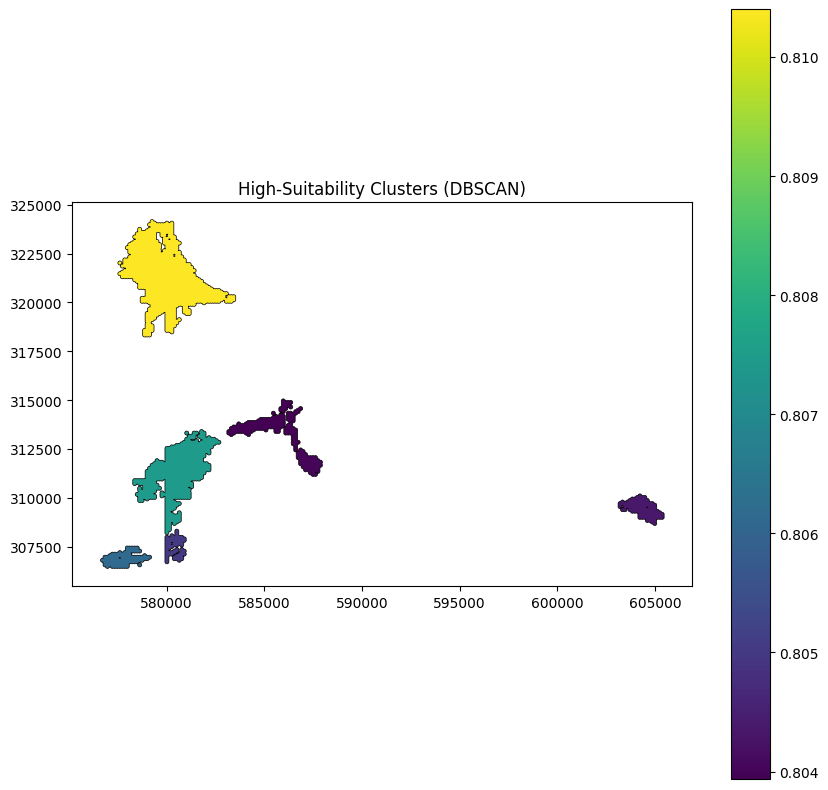

In [28]:
fig, ax = plt.subplots(figsize=(10, 10))

cluster_polys.plot(column="mean_suitability",
                   cmap="viridis",
                   legend=True,
                   ax=ax,
                   edgecolor="black",
                   linewidth=0.5)

ax.set_title("High-Suitability Clusters (DBSCAN)")
plt.show()

The above plot shows several suitable clusters can be identified in the AOI

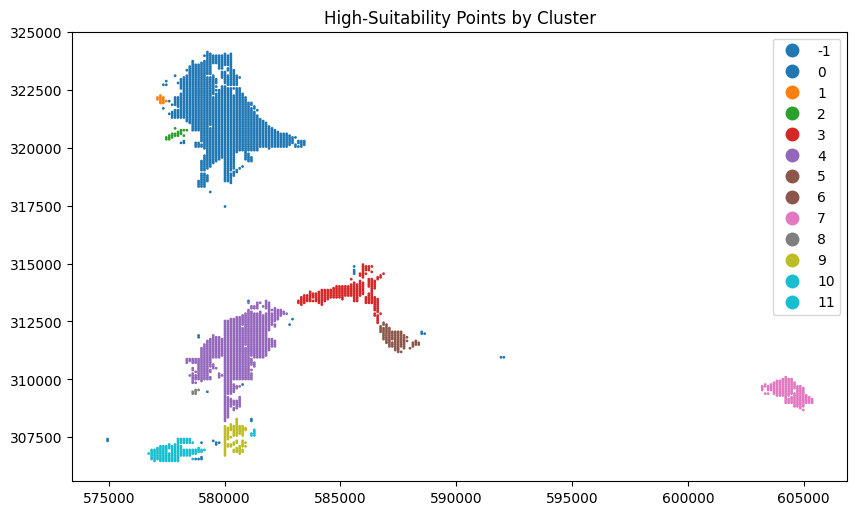

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))

gdf.plot(column="cluster",
         categorical=True,
         legend=True,
         s=1,
         ax=ax)

ax.set_title("High-Suitability Points by Cluster")
plt.show()

The above plut differentiates the clusters clearly by colour

/usr/local/lib/python3.12/dist-packages/matplotlib/colors.py:2294: RuntimeWarning: overflow encountered in divide
  resdat /= (vmax - vmin)


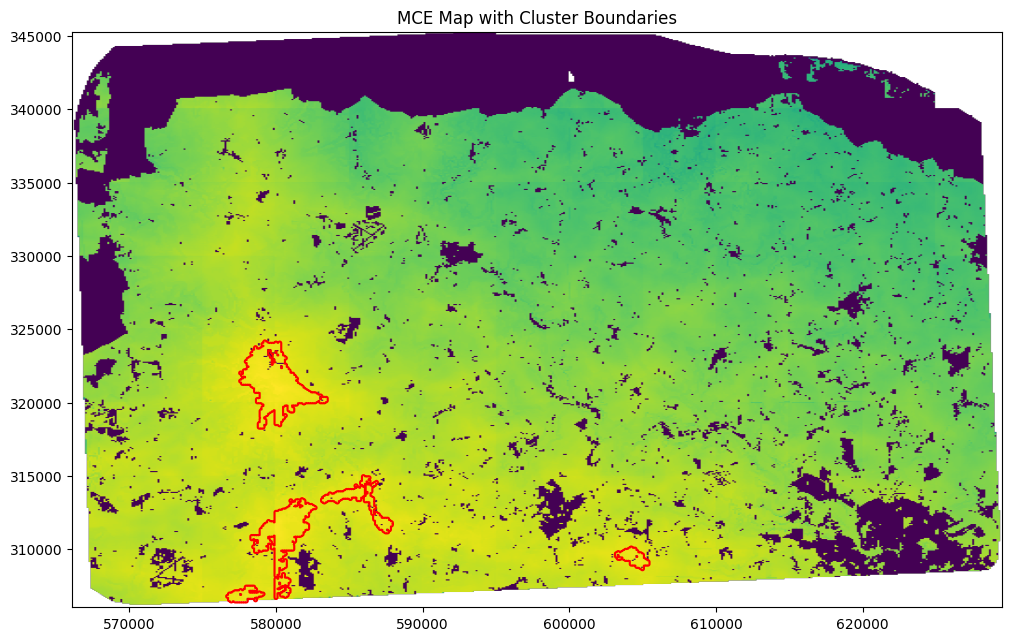

In [29]:
with rasterio.open("/content/drive/MyDrive/Colab Notebooks/GG3209_Final/data/Final data/MCE_Map.tif") as src:
    fig, ax = plt.subplots(figsize=(12, 12))
    show(src, ax=ax, cmap="viridis")
    cluster_polys.boundary.plot(ax=ax, edgecolor="red")
    ax.set_title("MCE Map with Cluster Boundaries")
    plt.show()

The above plot shows the clusters relative to the MCE map

In [30]:
cluster_polys["rank_suitability"] = cluster_polys["mean_suitability"].rank(ascending=False)


In [31]:
cluster_polys["score"] = cluster_polys["mean_suitability"] * cluster_polys["area_m2"]
cluster_polys["rank_score"] = cluster_polys["score"].rank(ascending=False)


In [32]:
top10 = cluster_polys.sort_values("score", ascending=False).head(10)

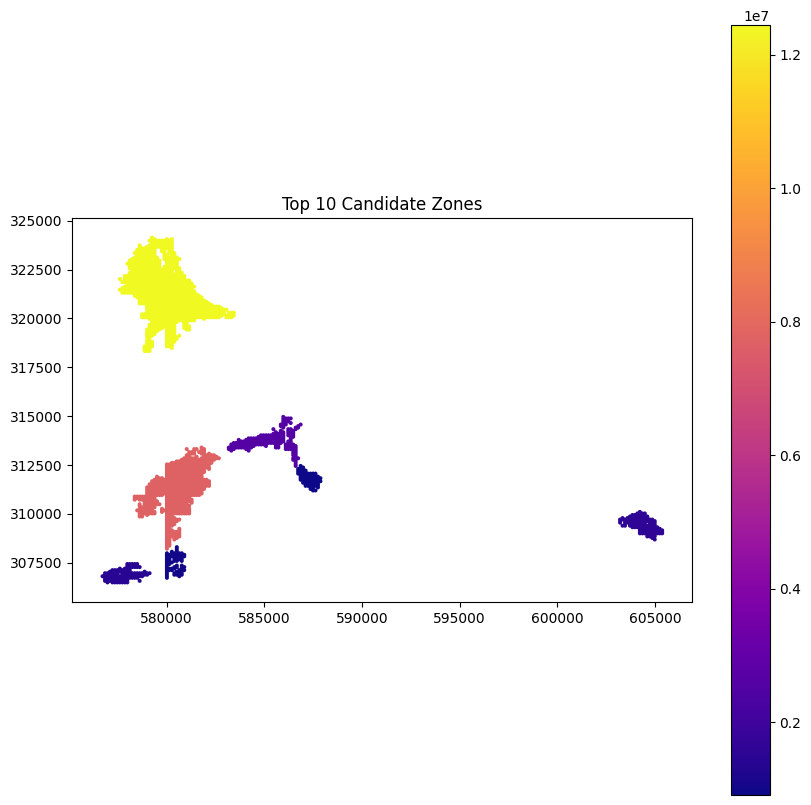

In [33]:
fig, ax = plt.subplots(figsize=(10, 10))
top10.plot(column="score", cmap="plasma", legend=True, ax=ax)
ax.set_title("Top 10 Candidate Zones")
plt.show()

The above plot shows the top zones for construction of a windfarm

<Axes: >

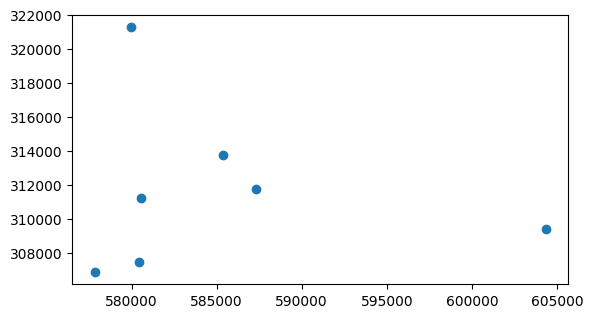

In [34]:
cluster_polys["centroid"] = cluster_polys.geometry.centroid
centroids = cluster_polys.set_geometry("centroid")
centroids.plot()

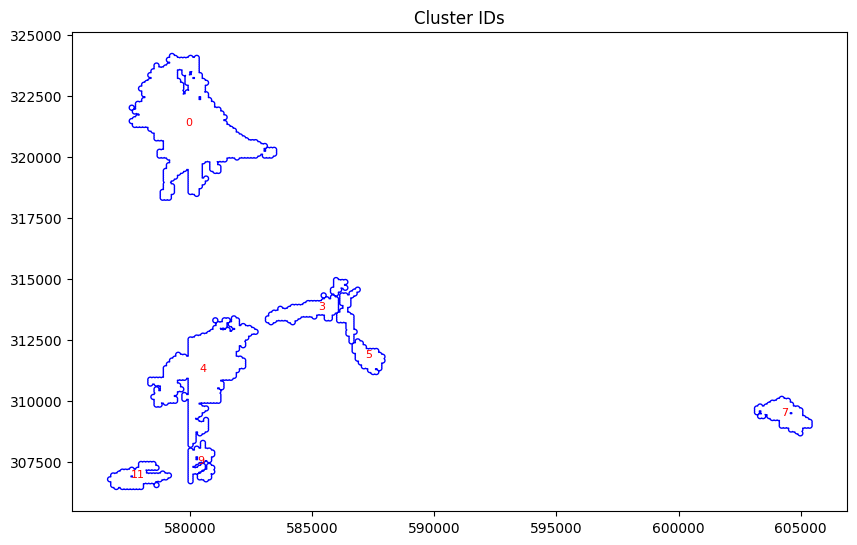

In [35]:
fig, ax = plt.subplots(figsize=(10, 10))
cluster_polys.plot(ax=ax, facecolor="none", edgecolor="blue")

# Add labels
for idx, row in cluster_polys.iterrows():
    ax.annotate(text=row["cluster"], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                ha="center", fontsize=8, color="red")

ax.set_title("Cluster IDs")
plt.show()

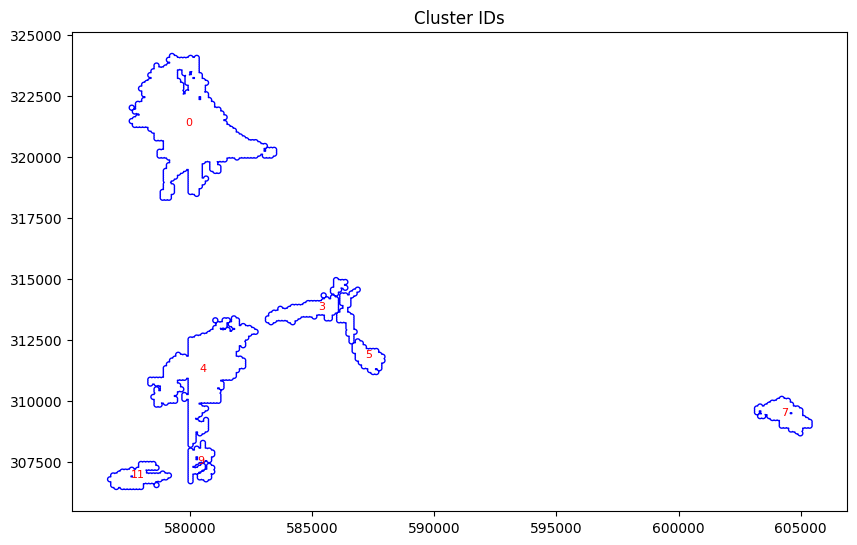

In [36]:
fig, ax = plt.subplots(figsize=(10, 10))
cluster_polys.plot(ax=ax, facecolor="none", edgecolor="blue")

for idx, row in cluster_polys.iterrows():
    ax.annotate(text=row["cluster"], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                ha="center", fontsize=8, color="red")

ax.set_title("Cluster IDs")
plt.show()

In [37]:
cluster_polys.explore(
    column="mean_suitability",
    cmap="viridis",
    tooltip=["cluster", "mean_suitability", "area_m2"]
)

The above shows a highly useful interactive map allowing clusters to be visualised with an open source map

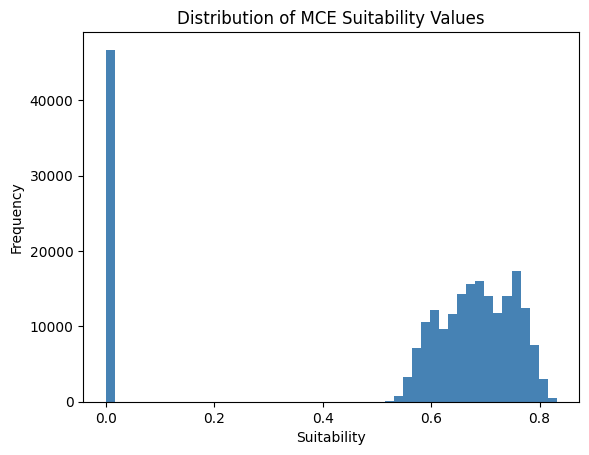

In [38]:
plt.hist(mce.flatten(), bins=50, color='steelblue')
plt.title("Distribution of MCE Suitability Values")
plt.xlabel("Suitability")
plt.ylabel("Frequency")
plt.show()

The above plot shows distrubution of suitability values. This is a skewed graph as everything below 80% (0.8) was discounted

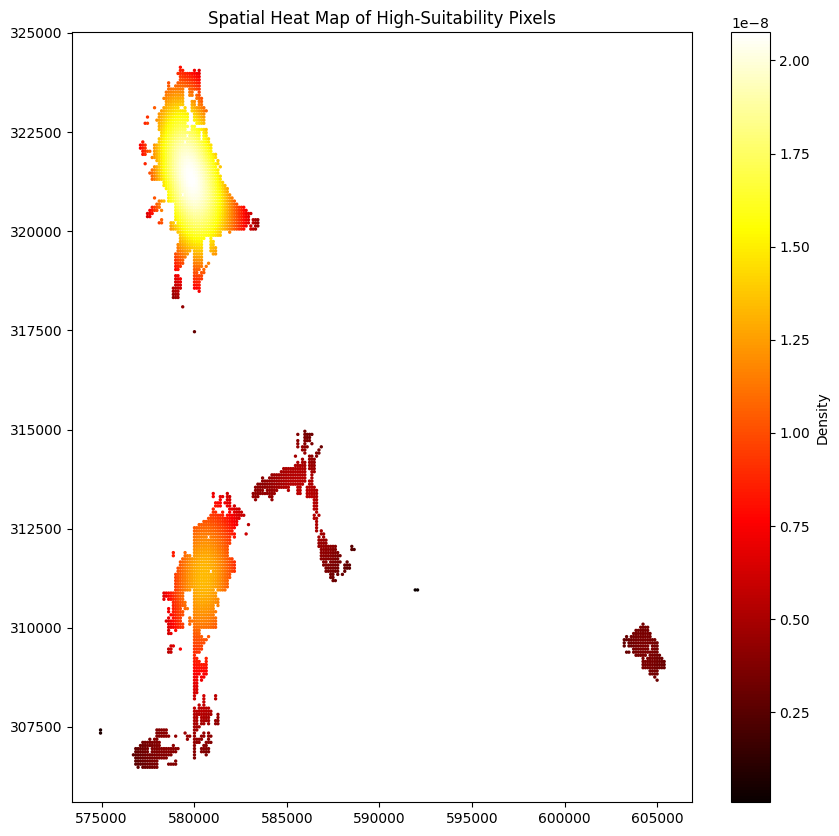

In [39]:
coords = np.vstack([gdf.x, gdf.y])
kde = gaussian_kde(coords)
density = kde(coords)

plt.figure(figsize=(10, 10))
plt.scatter(gdf.x, gdf.y, c=density, s=2, cmap='hot')
plt.title("Spatial Heat Map of High-Suitability Pixels")
plt.colorbar(label="Density")
plt.show()

The above heatmap displays density of suitable areas

# Discussion

The results from this study provided basis for both large scale wind farms as well as clusters of small ones in the area. There are many benefits of a distributed generation model for energy production such as resilience, stability and reduced losses through transportation (IPCC, 2022) Energy gets lost as it travels from place to place so an energy source closer to its destination is more efficient. Another benefit is energy grid resilience, a concentrated energy source that goes down could be due to many factors such as wiring issues, lack of wind etc. however it all has the same effect, a large loss of power to the national grid. A distributed systems mitigates an outage to a small area.

However, there are benefits to large sites also. Producing one large site is a much lower investment due to economies of scale (WindEurope 2021). A large-scale farm costs less to build and reduces maintenance cost as it can again be done at a larger scale and requires less distribution infrastructure. This also increases the likelihood of a well-maintained system reducing chances of energy blackspots.

Onshore wind should also be a more valued area of interest due to the reduced logistical challenges associated allowing a lower initial investment for developers. The challenge is added when it comes to competing land use for urban areas as well as areas of natural beauty and other protected locations.

From the research conducted it was seen that no site was more than 85% suitable based on the Factors and constraints provided, this is sub optimal as across the country there are many more suitable sites however the area of East Anglia is in a prime location to build due to its surroundings. It is located directly near a large offshore windfarm with pre-existing infrastructure that can more readily be expanded. It is also north of London and south of Birmingham, two large urban locations with high energy demands.


# Conclusion

In conclusion many areas in the AOI were deemed to be suitable according to the various factors and constraints to the point where it was more effective to narrow down to places with 80%+ levels of suitability, with key clusters being identified based on this suitability. There were several clusters of varying size across the area so with a mixed dispersion, concentration approach all sites can be used. On the other hand the area is also suitable for large scale or small scale solo approaches. Further analysis is required to narrow down further using more sources of data for constraints that were outside the scope of this project such as bird migration patterns, buffer zones legally enforced as well as flood risks to name a few.

# Appendix

In [2]:
import rasterio as rio

/usr/local/lib/python3.12/dist-packages/matplotlib/colors.py:2294: RuntimeWarning: overflow encountered in divide
  resdat /= (vmax - vmin)


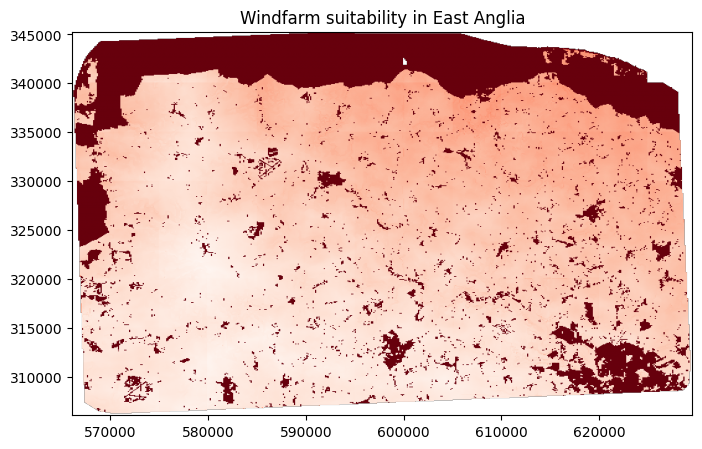

<Axes: title={'center': 'Windfarm suitability in East Anglia'}>

In [49]:
Suitability = rio.open("/content/drive/MyDrive/Colab Notebooks/GG3209_Final/data/Final data/MCE_Map.tif")
plt.figure(figsize=(8, 6))
plt.title( 'Windfarm suitability in East Anglia')
show(Suitability, cmap= 'Reds_r')

/usr/local/lib/python3.12/dist-packages/matplotlib/colors.py:777: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


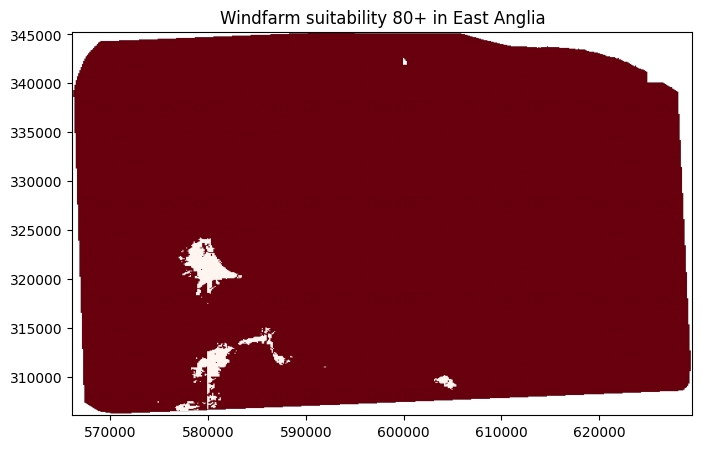

<Axes: title={'center': 'Windfarm suitability 80+ in East Anglia'}>

In [50]:
eighty_plus = rio.open("/content/drive/MyDrive/Colab Notebooks/GG3209_Final/data/Final data/Suitable_Eighty.tif")
plt.figure(figsize=(8, 6))
plt.title( 'Windfarm suitability 80+ in East Anglia')
show(eighty_plus, cmap= 'Reds_r')

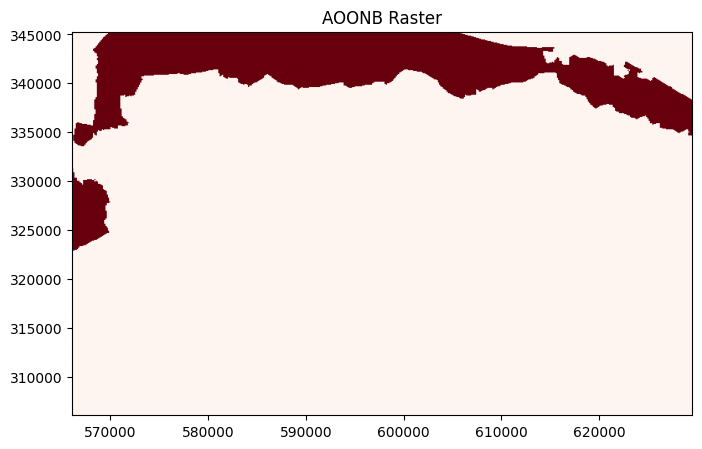

<Axes: title={'center': 'AOONB Raster'}>

In [51]:
AOONB = rio.open("/content/drive/MyDrive/Colab Notebooks/GG3209_Final/data/Final data/Rasters_final/AOONB_mask.tif")
plt.figure(figsize=(8, 6))
plt.title( 'AOONB Raster')
show(AOONB, cmap= 'Reds_r')

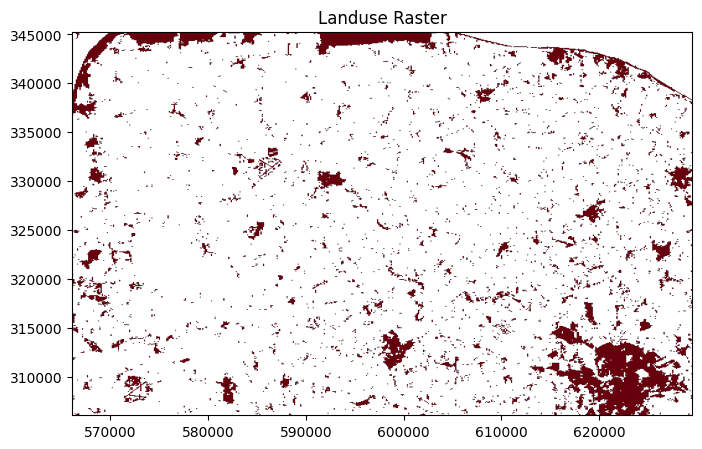

<Axes: title={'center': 'Landuse Raster'}>

In [53]:
Landuse = rio.open("/content/drive/MyDrive/Colab Notebooks/GG3209_Final/data/Final data/Rasters_final/Landuse_constraint.tif")
plt.figure(figsize=(8, 6))
plt.title( 'Landuse Raster')
show(Landuse, cmap= 'Reds_r')

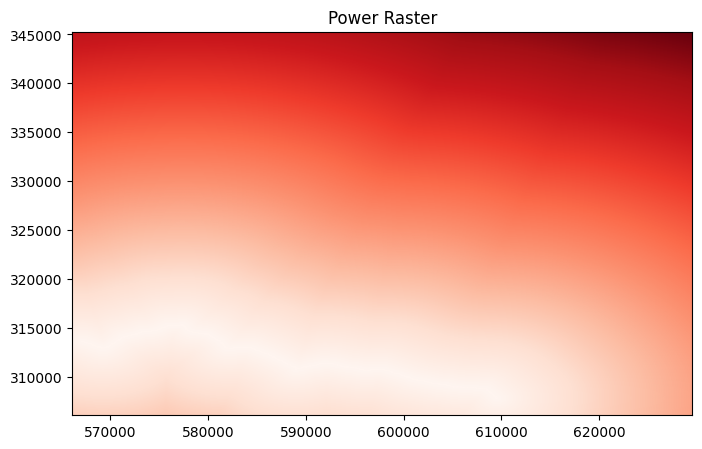

<Axes: title={'center': 'Power Raster'}>

In [54]:
Power = rio.open("/content/drive/MyDrive/Colab Notebooks/GG3209_Final/data/Final data/Rasters_final/Power_normalised.tif")
plt.figure(figsize=(8, 6))
plt.title( 'Power Raster')
show(Power, cmap= 'Reds_r')

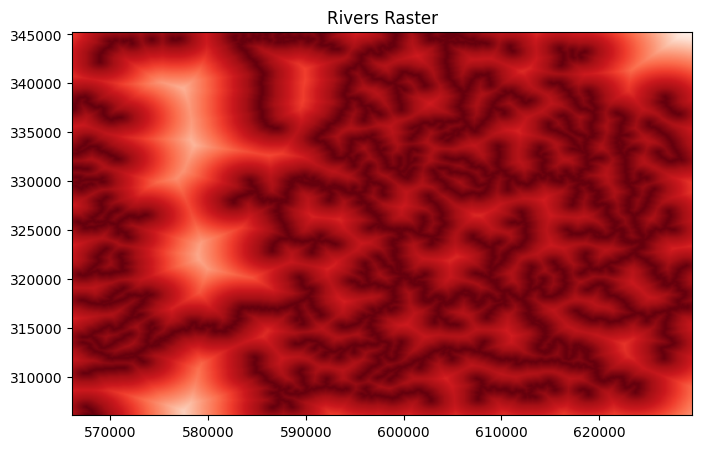

<Axes: title={'center': 'Rivers Raster'}>

In [56]:
Rivers = rio.open("/content/drive/MyDrive/Colab Notebooks/GG3209_Final/data/Final data/Rasters_final/Rivers_Factor.tif")
plt.figure(figsize=(8, 6))
plt.title( 'Rivers Raster')
show(Rivers, cmap= 'Reds_r')

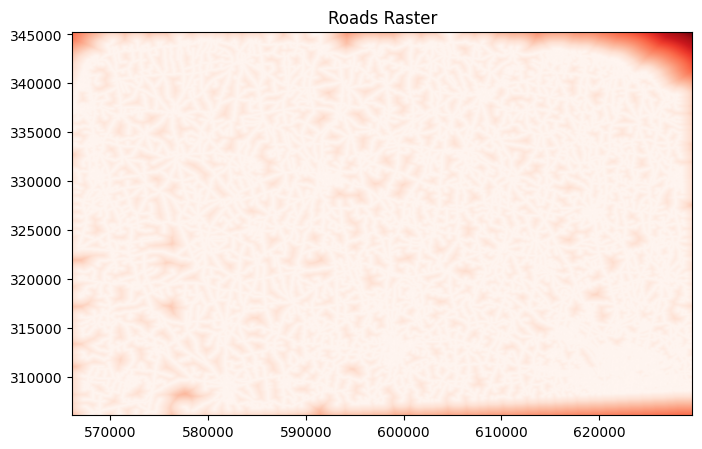

<Axes: title={'center': 'Roads Raster'}>

In [6]:
Roads = rio.open("/content/drive/MyDrive/Colab Notebooks/GG3209_Final/data/Final data/Rasters_final/Roads_normalised.tif")
plt.figure(figsize=(8, 6))
plt.title( 'Roads Raster')
show(Roads, cmap= 'Reds_r')

/usr/local/lib/python3.12/dist-packages/matplotlib/colors.py:777: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


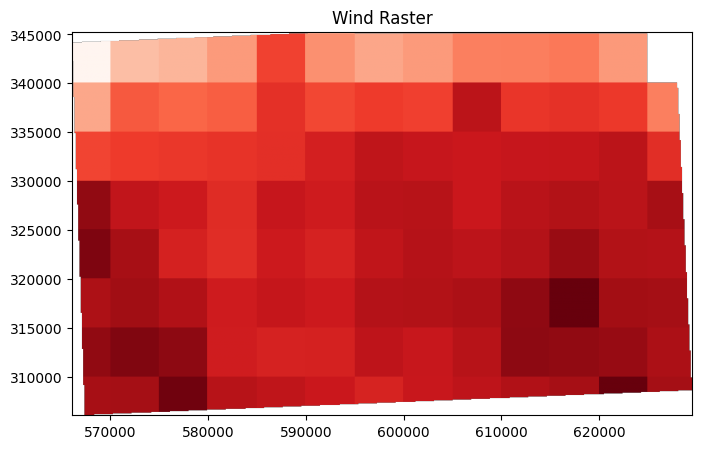

<Axes: title={'center': 'Wind Raster'}>

In [7]:
Wind = rio.open("/content/drive/MyDrive/Colab Notebooks/GG3209_Final/data/Final data/Rasters_final/Wind_Normalised.tif")
plt.figure(figsize=(8, 6))
plt.title( 'Wind Raster')
show(Wind, cmap= 'Reds_r')

# References

Reference listClimate Change Committee (2025). Progress in reducing emissions - 2025 report to Parliament - Climate Change Committee. [online] Climate Change Committee. Available at: https://www.theccc.org.uk/publication/progress-in-reducing-emissions-2025-report-to-parliament/.Gov, H. (2025). Energy Trends. [online] Available at: https://assets.publishing.service.gov.uk/media/692d7e9d345e31ab14ecf7cf/Energy_Trends_September_2025.pdf [Accessed 9 Dec. 2025].HM Government (2021). Net Zero Strategy: Build Back Greener. [online] gov.uk. UK Government. Available at: https://assets.publishing.service.gov.uk/media/6194dfa4d3bf7f0555071b1b/net-zero-strategy-beis.pdf.IPCC (2022). Climate Change 2022: Mitigation of Climate Change. [online] IPCC. Available at: https://www.ipcc.ch/report/ar6/wg3/.Ministry of Housing, Communities and Local Government (2024). National Planning Policy Framework. [online] GOV.UK. Available at: https://assets.publishing.service.gov.uk/media/67aafe8f3b41f783cca46251/NPPF_December_2024.pdf.renewableUK (n.d.). The onshore wind industry prospectus years 4 0. [online] Available at: https://www.renewableuk.com/media/c55ckdrg/onshore-wind-industry-prospectus_2021.pdf.scottishpowerrenewables.com. (2022). East Anglia ONE - ScottishPower Renewables - scottishpowerrenewables.com. [online] Available at: https://www.scottishpowerrenewables.com/offshore/east-anglia/east-anglia-one.WindEurope. (2025). WindEurope Intelligence Platform. [online] Available at: https://windeurope.org/data/.

## Data

Ordanance Survey

National Grid

Road Network

ESRI

England Nature

HM Government

Digimaps